In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization

import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
from sklearn.metrics import classification_report

# to persist the model and the scaler
import joblib

# ========== NEW IMPORTS ========
# Respect to notebook 02-Predicting-Survival-Titanic-Solution

# pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


# for the preprocessors
from sklearn.preprocessing import MinMaxScaler, Binarizer

# for imputation


# for encoding categorical variables
# from feature-engine

from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
    OneHotEncoder,
    MeanEncoder
)

from feature_engine.transformation import LogTransformer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropFeatures, SelectByTargetMeanPerformance
from feature_engine.wrappers import SklearnTransformerWrapper
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
#import preprocessors as pp

In [2]:
# load dataset
#data = pd.read_csv('../data/raw/dls/train.csv')
train_data = pd.read_csv('../data/interim/train_data_pr.csv')
validation_data = pd.read_csv('../data/interim/validation_data_pr.csv')
# rows and columns of the data
print(train_data.shape)

# visualise the dataset
train_data.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/train_data_pr.csv'

In [3]:
# list of variables to be used in the pipeline's transformers
TARGET = 'Churn'

NUMERICAL_VARIABLES = list(train_data.select_dtypes(include = np.number).columns)
NUMERICAL_VARIABLES.remove(TARGET)

NUMERIC_VARIABLES_WITH_NA = [col for col in NUMERICAL_VARIABLES if train_data[col].isnull().sum() > 0]


CATEGORICAL_VARIABLES = list(train_data.select_dtypes(exclude = np.number).columns)
CATEGORICAL_VARIABLES_WITH_NA = [col for col in CATEGORICAL_VARIABLES if train_data[col].isnull().sum() > 0]


C=1#0.0005

RANDOM_STATE =123

In [4]:
X_train, X_val = train_data.drop(TARGET, axis = 1), validation_data.drop(TARGET, axis = 1), 
y_train, y_val = train_data[TARGET], validation_data[TARGET]

In [5]:
train_data[CATEGORICAL_VARIABLES]

Contract PaperlessBilling              PaymentMethod  gender  \
0           Two year              Yes  Bank transfer (automatic)    Male   
1     Month-to-month              Yes           Electronic check  Female   
2           Two year               No  Bank transfer (automatic)  Female   
3     Month-to-month              Yes           Electronic check    Male   
4     Month-to-month               No  Bank transfer (automatic)    Male   
...              ...              ...                        ...     ...   
5629        One year               No    Credit card (automatic)    Male   
5630  Month-to-month              Yes  Bank transfer (automatic)  Female   
5631  Month-to-month              Yes  Bank transfer (automatic)  Female   
5632  Month-to-month               No  Bank transfer (automatic)    Male   
5633  Month-to-month              Yes           Electronic check  Female   

     SeniorCitizen Partner Dependents PhoneService MultipleLines  \
0              Yes     Yes         No          Yes           Yes   
1              Yes      No        Yes          Yes            No   
2               No     Yes         No          Yes           Yes   
3              Yes     Yes         No          Yes           Yes   
4               No      No         No          Yes            No   
...            ...     ...        ...          ...           ...   
5629           Yes     Yes         No          Yes           Yes   
5630            No      No        Yes          Yes            No   
5631            No      No         No          Yes           Yes   
5632            No      No         No          Yes           Yes   
5633           Yes     Yes         No          Yes           Yes   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0                 No            NaN          NaN              NaN         NaN   
1        Fiber optic             No           No               No          No   
2                 No            NaN          NaN              NaN         NaN   
3        Fiber optic             No          Yes               No          No   
4        Fiber optic            Yes           No               No          No   
...              ...            ...          ...              ...         ...   
5629              No            NaN          NaN              NaN         NaN   
5630     Fiber optic            Yes          Yes              Yes          No   
5631     Fiber optic             No          Yes              Yes          No   
5632             DSL            Yes           No               No         Yes   
5633     Fiber optic             No          Yes              Yes          No   

     StreamingTV StreamingMovies  
0            NaN             NaN  
1             No              No  
2            NaN             NaN  
3            Yes             Yes  
4             No              No  
...          ...             ...  
5629         NaN             NaN  
5630         Yes             Yes  
5631         Yes             Yes  
5632          No              No  
5633         Yes             Yes  

[5634 rows x 16 columns]

In [6]:
# X, y = data.drop(TARGET, axis=1), data[TARGET]


# #y = y.drop(X[X.duplicated(keep = 'first')].index)
# #X = X.drop_duplicates(keep = 'first')
# X_train, X_test, y_train, y_test = train_test_split(
#     X,  # predictors
#     y,  # target
#     test_size=0.2,  # percentage of obs in test set
#     random_state=RANDOM_STATE,
# stratify=y)  # seed to ensure reproducibility

# X_train.shape, X_test.shape

In [7]:
import numpy as np 
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# clf = CatBoostClassifier(loss_function='MultiClassOneVsAll', class_weights=class_weights)
# clf.fit(X_train, y_train)

## Churn pipeline

In [22]:
CATEGORICAL_VARIABLES_WITH_NA

['MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [56]:
# set up the pipeline

#def make_pipeline():
    
churn_pipe = Pipeline([

    # ===== IMPUTATION =====
        # add missing indicator to numerical variables
    ('missing_indicator_cat', AddMissingIndicator(variables = CATEGORICAL_VARIABLES)),
    # impute categorical variables with string 'missing'
    ('categorical_imputation', CategoricalImputer(imputation_method ='missing',
                                                  variables=CATEGORICAL_VARIABLES_WITH_NA)),

    # add missing indicator to numerical variables
    ('missing_indicator_num', AddMissingIndicator(variables = NUMERICAL_VARIABLES)),

    # impute numerical variables with the median
    ('median_imputation', MeanMedianImputer(imputation_method = 'median',
                                           variables= NUMERIC_VARIABLES_WITH_NA)),


    # Extract first letter from cabin
    #('extract_letter', ExtractLetterTransformer(variables=['cabin'])),


    # == CATEGORICAL ENCODING ======
    # remove categories present in less than 5% of the observations (0.05)
    # group them in one category called 'Rare'
#     ('rare_label_encoder', RareLabelEncoder(tol = 0.05,
#                                            replace_with = "Rare",
#                                            variables=CATEGORICAL_VARIABLES)),


    # encode categorical variables using one hot encoding into k-1 variables
    ('categorical_encoder', OneHotEncoder(variables=CATEGORICAL_VARIABLES)),
#     ('mean_encoder', MeanEncoder(
#     variables = None,
    #ignore_format=True,
#)),
    # scale using standardization
    #('scaler', StandardScaler()),
    #('scaler', StandardScaler()),
    #('feature_selection',SelectByTargetMeanPerformance(scoring = 'f1')),
    # logistic regression (use C=0.0005 and random_state=0)
    #('winsorizer', Winsorizer(tail = 'both',)),

    #('Logit', LogisticRegression(C=C, random_state=RANDOM_STATE, 
         #                        class_weight='balanced',
         #                       )),
#     ('cat', CatBoostClassifier(iterations = 500,class_weights=class_weights, 
#                                cat_features= CATEGORICAL_VARIABLES))
    ('xgboost', XGBClassifier(n_estimators = 50))
])

In [57]:
churn_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_indicator_cat',
                 AddMissingIndicator(variables=['Contract', 'PaperlessBilling',
                                                'PaymentMethod', 'gender',
                                                'SeniorCitizen', 'Partner',
                                                'Dependents', 'PhoneService',
                                                'MultipleLines',
                                                'InternetService',
                                                'OnlineSecurity',
                                                'OnlineBackup',
                                                'DeviceProtection',
                                                'TechSupport', 'StreamingTV',
                                                'StreamingMovies'])),
                ('categorical_imputation',
                 Categoric...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [25]:
X_train_tr= churn_pipe.transform(X_train)
X_val_tr= churn_pipe.transform(X_val)

In [12]:
cat = CatBoostClassifier(iterations = 500, class_weights=class_weights, verbose=0)

In [13]:
cat_cols = X_train_tr.select_dtypes('object').columns
cat_index = []
for index, val in enumerate(X_train_tr.columns):
    if val in cat_cols:
        cat_index.append(index)

In [14]:
cat_index

[1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [15]:
cat.fit(X_train_tr, y_train, eval_set = (X_val_tr, y_val), plot = True,
       cat_features= cat_index)

C:\Users\Pavel\anaconda3\envs\churn_develop\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
X_train_tr

tenure        Contract PaperlessBilling              PaymentMethod  \
0         72        Two year              Yes  Bank transfer (automatic)   
1          1  Month-to-month              Yes           Electronic check   
2         69        Two year               No  Bank transfer (automatic)   
3         58  Month-to-month              Yes           Electronic check   
4         25  Month-to-month               No  Bank transfer (automatic)   
...      ...             ...              ...                        ...   
5629      45        One year               No    Credit card (automatic)   
5630      34  Month-to-month              Yes  Bank transfer (automatic)   
5631      37  Month-to-month              Yes  Bank transfer (automatic)   
5632      20  Month-to-month               No  Bank transfer (automatic)   
5633      60  Month-to-month              Yes           Electronic check   

      MonthlyCharges  TotalCharges  gender SeniorCitizen Partner Dependents  \
0              25.00       1802.55    Male           Yes     Yes         No   
1              71.00         71.00  Female           Yes      No        Yes   
2              24.25       1641.80  Female            No     Yes         No   
3              98.90       5780.70    Male           Yes     Yes         No   
4              74.30       1952.25    Male            No      No         No   
...              ...           ...     ...           ...     ...        ...   
5629           24.70       1174.35    Male           Yes     Yes         No   
5630          105.35       3688.60  Female            No      No        Yes   
5631          101.90       3545.35  Female            No      No         No   
5632           59.20       1191.20    Male            No      No         No   
5633          105.90       6401.25  Female           Yes     Yes         No   

      ... StreamingTV StreamingMovies MultipleLines_na OnlineSecurity_na  \
0     ...     Missing         Missing                0                 1   
1     ...          No              No                0                 0   
2     ...     Missing         Missing                0                 1   
3     ...         Yes             Yes                0                 0   
4     ...          No              No                0                 0   
...   ...         ...             ...              ...               ...   
5629  ...     Missing         Missing                0                 1   
5630  ...         Yes             Yes                0                 0   
5631  ...         Yes             Yes                0                 0   
5632  ...          No              No                0                 0   
5633  ...         Yes             Yes                0                 0   

     OnlineBackup_na DeviceProtection_na TechSupport_na StreamingTV_na  \
0                  1                   1              1              1   
1                  0                   0              0              0   
2                  1                   1              1              1   
3                  0                   0              0              0   
4                  0                   0              0              0   
...              ...                 ...            ...            ...   
5629               1                   1              1              1   
5630               0                   0              0              0   
5631               0                   0              0              0   
5632               0                   0              0              0   
5633               0                   0              0              0   

     StreamingMovies_na  TotalCharges_na  
0                     1                0  
1                     0                0  
2                     1                0  
3                     0                0  
4                     0                0  
...                 ...              ...  
5629                  1                0 

In [45]:
model = XGBClassifier(n_estimators = 10)
model.fit(X_train_tr, y_train, eval_set = [(X_train_tr, y_train),(X_val_tr, y_val)])

[0]	validation_0-logloss:0.57030	validation_1-logloss:0.57768
[1]	validation_0-logloss:0.50124	validation_1-logloss:0.51642
[2]	validation_0-logloss:0.45647	validation_1-logloss:0.47989
[3]	validation_0-logloss:0.42626	validation_1-logloss:0.45708
[4]	validation_0-logloss:0.40576	validation_1-logloss:0.44256
[5]	validation_0-logloss:0.38852	validation_1-logloss:0.43440
[6]	validation_0-logloss:0.37632	validation_1-logloss:0.42931
[7]	validation_0-logloss:0.36668	validation_1-logloss:0.42703
[8]	validation_0-logloss:0.35860	validation_1-logloss:0.42686
[9]	validation_0-logloss:0.35274	validation_1-logloss:0.42626


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [46]:
from matplotlib import pyplot

In [47]:
model.evals_result_.keys()

dict_keys(['validation_0', 'validation_1'])

Accuracy: 0.801


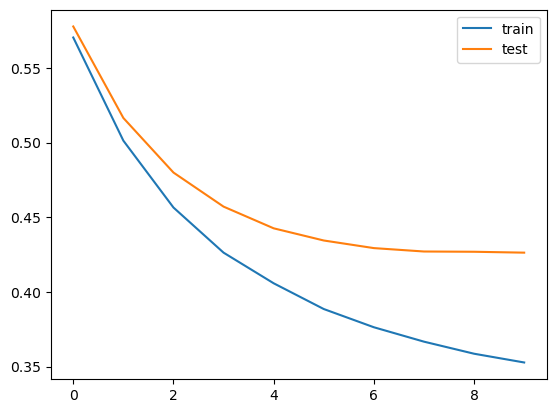

In [48]:
yhat = model.predict(X_val_tr)
score = accuracy_score(y_val, yhat)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [16]:
# train the pipeline

churn_pipe.fit(X_train, y_train, va)

NameError: name 'va' is not defined

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [58]:
# make predictions for train set
class_ = churn_pipe.predict(X_train)
pred = churn_pipe.predict_proba(X_train)[:,1]
precision, recall, thresholds = precision_recall_curve(y_train, pred)
# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = churn_pipe.predict(X_val)
pred = churn_pipe.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, pred)
f1_metric, auc_metric = f1_score(y_val, class_), auc(recall, precision)
# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_val, pred)))
print('test accuracy: {}'.format(accuracy_score(y_val, class_)))
print()

train roc-auc: 0.9578455526636668
train accuracy: 0.8919062832800851

test roc-auc: 0.8220698028882171
test accuracy: 0.7899219304471257



In [35]:
# make predictions for train set
class_ = churn_pipe.predict(X_train)
pred = churn_pipe.predict_proba(X_train)[:,1]
precision, recall, thresholds = precision_recall_curve(y_train, pred)
# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = churn_pipe.predict(X_val)
pred = churn_pipe.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, pred)
f1_metric, auc_metric = f1_score(y_val, class_), auc(recall, precision)
# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_val, pred)))
print('test accuracy: {}'.format(accuracy_score(y_val, class_)))
print()

train roc-auc: 0.9362524352334956
train accuracy: 0.8450479233226837

test roc-auc: 0.8339972616187449
test accuracy: 0.759403832505323



In [59]:
print('Logistic: f1=%.3f auc=%.3f' % (f1_metric, auc_metric))

Logistic: f1=0.569 auc=0.628


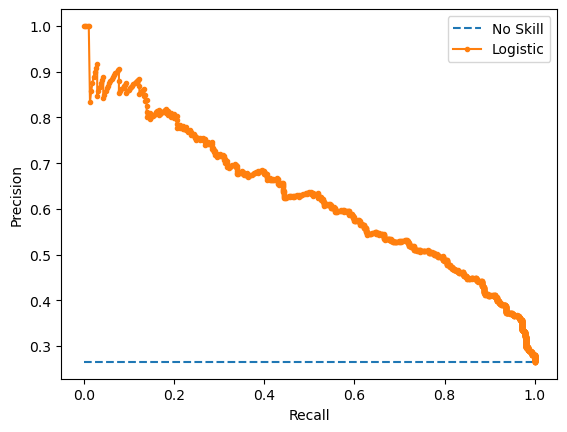

In [60]:
from matplotlib import pyplot
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

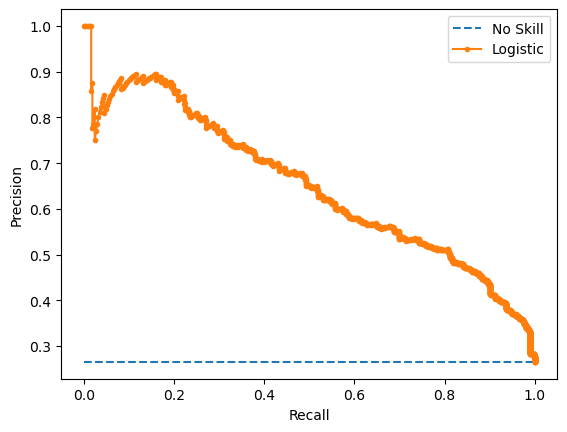

In [37]:
from matplotlib import pyplot
# plot the precision-recall curves
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.843


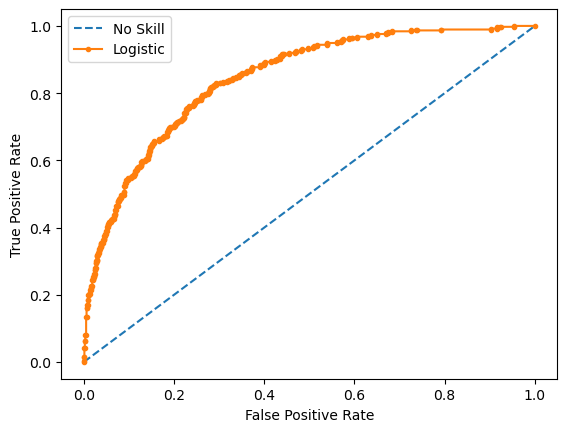

In [96]:
lr_probs = pred
ns_probs = [0 for _ in range(len(y_val))]
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [61]:
print(classification_report(y_val, np.where(pred > 0.5,1,0)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.62      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [97]:
print(classification_report(y_val, np.where(pred > 0.5,1,0)))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [21]:
print(classification_report(y_val, np.where(pred > 0.5,1,0)))

              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [454]:
print(classification_report(y_test, np.where(pred > 0.5,1,0)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       780
           1       0.57      0.73      0.64       277

    accuracy                           0.78      1057
   macro avg       0.73      0.76      0.74      1057
weighted avg       0.81      0.78      0.79      1057



### Predict

In [485]:
data_test['IsSeniorCitizen'] = data_test['IsSeniorCitizen'].map({1:'Yes',
                                                      0:'No'})
data_test['TotalSpent'] = pd.to_numeric(data_test['TotalSpent'], errors = 'coerce')
data_test['IsSeniorCitizen'].fillna(X_train['IsSeniorCitizen'].mode()[0], inplace = True)

In [469]:
data_test

ClientPeriod  MonthlySpending  TotalSpent     Sex IsSeniorCitizen  \
0               42            56.10     2386.85    Male             NaN   
1               29            98.50     3004.15    Male             NaN   
2                9            76.25      684.85    Male             NaN   
3               67            74.00     4868.40  Female             NaN   
4               71            20.10     1389.60  Female             NaN   
...            ...              ...         ...     ...             ...   
1756            71           105.15     7555.00  Female             NaN   
1757            13            20.85      272.35  Female             NaN   
1758             2            91.45      171.45    Male             NaN   
1759            19            89.10     1620.80  Female             NaN   
1760            72            65.60     4566.50    Male             NaN   

     HasPartner HasChild HasPhoneService HasMultiplePhoneNumbers  \
0           Yes       No             Yes                     Yes   
1           Yes       No             Yes                     Yes   
2            No       No             Yes                     Yes   
3           Yes      Yes             Yes                     Yes   
4           Yes      Yes             Yes                      No   
...         ...      ...             ...                     ...   
1756        Yes       No             Yes                     Yes   
1757        Yes      Yes             Yes                      No   
1758        Yes       No             Yes                     Yes   
1759        Yes       No             Yes                     Yes   
1760         No       No              No                     NaN   

     HasInternetService HasOnlineSecurityService HasOnlineBackup  \
0                   DSL                      Yes              No   
1           Fiber optic                       No              No   
2           Fiber optic                       No              No   
3                   DSL                      Yes             Yes   
4                    No                      NaN             NaN   
...                 ...                      ...             ...   
1756        Fiber optic                       No             Yes   
1757                 No                      NaN             NaN   
1758        Fiber optic                       No              No   
1759        Fiber optic                       No             Yes   
1760                DSL                      Yes             Yes   

     HasDeviceProtection HasTechSupportAccess HasOnlineTV  \
0                     No                   No          No   
1                    Yes                   No         Yes   
2                     No                   No          No   
3                     No                  Yes         Yes   
4                    NaN                  NaN         NaN   
...                  ...                  ...         ...   
1756                 Yes                   No         Yes   
1757                 NaN                  NaN         NaN   
1758                 Yes                   No         Yes   
1759                  No                   No          No   
1760                 Yes                  Yes         Yes   

     HasMovieSubscription HasContractPhone IsBillingPaperless  \
0                      No         One year                 No   
1                     Yes   Month-to-month                Yes   
2                      No   Month-to-month                Yes   
3                      No         Two year                 No   
4                     NaN         Two year                 No   
...                   ...              ...                ...   
1756                  Yes         Two year                Yes   
1757                  NaN         Two year                 No   
1758                   No   Month-to-month                Yes   
1759                  Yes   Month-to-month                Yes   
1760                  Y

In [489]:
new_predictions = churn_pipe.predict(data_test)

In [490]:
pd.Series(new_predictions).value_counts()

0    1140
1     621
dtype: int64